### Project Imports

In [1]:
# Imports
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import helper

import sessions
from sessions import TRAIN_CONFIG

from detectors import OpenCvDetector
from detectors import OPEN_CV_DETECTOR_CONFIG
from detectors import FaceKeyPointDetector

from models import KeyPointModelWithMonitor
from models import KEY_POINT_MODEL_CONFIG

from face_anonymizer import FaceAnonymizer

C:\Users\fixcfam\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Project Config

In [2]:
# configurate model
KEY_POINT_MODEL_CONFIG.X_PH_SHAPE = [None, 96, 96, 1]
KEY_POINT_MODEL_CONFIG.Y_PH_SHAPE = [None, 30]
KEY_POINT_MODEL_CONFIG.LEARNING_RATE = 0.001
# configurate train session
TRAIN_CONFIG.EPOCHS = 30
TRAIN_CONFIG.BATCH_SIZE = 64
TRAIN_CONFIG.DROPOUT_KEEP_PROB = 0.3
TRAIN_CONFIG.WRITE_SUMMARY = True
TRAIN_CONFIG.CHECKPOINT_DIR = os.path.join(".", "checkpoints")
TRAIN_CONFIG.SUMMARY_DIR = os.path.join(".", "summary")
# data set source: https://www.kaggle.com/c/facial-keypoints-detection/data
TRAIN_CONFIG.TRAIN_DATA_PATH = os.path.join(".", "data", "training.csv")
# configurate open cv detector
# detector architectures source: https://github.com/opencv/opencv/tree/master/data/haarcascades
OPEN_CV_DETECTOR_CONFIG.FACE_DETECTOR_FILE_PATH = os.path.join(".", "detector_architectures",
                                                               "haarcascade_frontalface_default.xml")
OPEN_CV_DETECTOR_CONFIG.EYE_DETECTOR_FILE_PATH = os.path.join(".", "detector_architectures",
                                                              "haarcascade_frontalface_default.xml")

### Set up and train Key Point Detection Model

In [3]:
# Set up key Point Model
key_point_model = KeyPointModelWithMonitor(KEY_POINT_MODEL_CONFIG)

In [4]:
# Train the model if needed
if not helper.check_checkpoints_available(TRAIN_CONFIG.CHECKPOINT_DIR):
    # Load data & train the model
    x_train, x_val, y_train, y_val = helper.load_train_data(TRAIN_CONFIG.TRAIN_DATA_PATH)
    sessions.train(key_point_model, x_train, y_train, x_val, y_val, TRAIN_CONFIG)
else:
    print("No Training. Checkpoint files available.")

No Training. Checkpoint files available.


### Facial Key Point Detection

In [5]:
# Set up Open Cv Detector(used for facedetection) and face key point detector
open_cv_detector = OpenCvDetector()
face_key_point_detector = FaceKeyPointDetector(model=key_point_model, 
                                               face_detector=open_cv_detector)

INFO:tensorflow:Restoring parameters from .\checkpoints\ckpt_2018_06_27__15_24_37.ckpt
1 faces detected


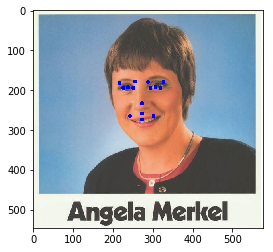

In [6]:
# Example for facial key point detection
sess_restore_dir = TRAIN_CONFIG.CHECKPOINT_DIR
# load and prepare image
image_bgr = cv2.imread(os.path.join("example_images", "merkel.jpg"))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# run facial key point detection session
face_key_points = sessions.facial_key_point_detection(image=image_rgb, 
                                                      face_key_point_detector=face_key_point_detector,
                                                      sess_restore_dir=sess_restore_dir,
                                                      scale_factor=2, 
                                                      min_neighbors=6)

# plot example image with detected keypoints
image_with_key_points = helper.add_keypoints_to_image(image_rgb, face_key_points)
plt.imshow(image_with_key_points)

### Face Anonymization

In [7]:
# Set up face anonymizer
face_anonymizer = FaceAnonymizer(face_key_point_detector=face_key_point_detector)

INFO:tensorflow:Restoring parameters from .\checkpoints\ckpt_2018_06_27__15_24_37.ckpt
1 faces detected


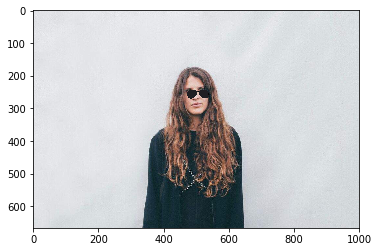

In [8]:
# Example for face anonymization
sess_restore_dir = TRAIN_CONFIG.CHECKPOINT_DIR
# load and prepare image
image_bgr = cv2.imread(os.path.join("example_images", "oathbreaker.jpg"))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sunglasses = cv2.imread(os.path.join("example_images", "sunglasses.png"), cv2.IMREAD_UNCHANGED)
reshaped_sunglasses = cv2.resize(sunglasses, (image_rgb.shape[1], image_rgb.shape[0]))

# run facial anonymisation session
anonymized_image = sessions.facial_anonymisation(image=image_rgb, 
                                                  overlay_image=reshaped_sunglasses, 
                                                  face_anonymizer=face_anonymizer,
                                                  sess_restore_dir=sess_restore_dir, 
                                                  scale_factor=2, 
                                                  min_neighbors=6)
# plot example image with facial anonymisation
plt.imshow(anonymized_image)